In [ ]:
#Based on
#https://towardsdatascience.com/training-efficientdet-object-detection-model-with-a-custom-dataset-25fb0f190555

In [ ]:
#our fork of the Tessellate-Imaging image detection library
#!rm -rf Monk_Object_Detection
! git clone https://github.com/roboflow-ai/Monk_Object_Detection.git

Cloning into 'Monk_Object_Detection'...
remote: Enumerating objects: 3747, done.
remote: Total 3747 (delta 0), reused 0 (delta 0), pack-reused 3747
Receiving objects: 100% (3747/3747), 132.20 MiB | 26.99 MiB/s, done.
Resolving deltas: 100% (800/800), done.
Checking out files: 100% (4032/4032), done.


In [ ]:
# For colab use the command below
# Set up library requirments
! cd Monk_Object_Detection/3_mxrcnn/installation && cat requirements_colab.txt | xargs -n 1 -L 1 pip install

     |████████████████████████████████| 352.6 MB 14 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
  Created wheel for dicttoxml: filename=dicttoxml-1.7.4-py3-none-any.whl size=17463 sha256=70690c2a114bdfc0b9c842e15c7eeb0724f1f5c9a050fb8358b72eca6c0bbf40
  Stored in directory: /root/.cache/pip/wheels/18/44/5a/c7b93703f611ae3b50820efbaf265413e6b183a56cbec6f661
Successfully built dicttoxml
  Cloning https://github.com/abhi-kumar/cocoapi.git to /tmp/pip-install-b9e8lxen/pycocotools_1411f2408f504082bbd8b44d7bfc9b97
  Running command git clone -q https://github.com/abhi-kumar/cocoapi.git /tmp/pip-install-b9e8lxen/pycocotools_1411f2408f504082bbd8b44d7bfc9b97
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263844 sha256=23f481f3c710f8d639ec295eddb3d5162508d09b78dc0d7ee9fa33df36718258
  Stored in directory: /tmp/pip-ephem-wheel-cac

In [ ]:
#fixed version of tqdm output for Colab
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
#IGNORE restart runtime warning, it is indeed installed
#missing a few extra packages that we will need later! 
!pip install efficientnet_pytorch
!pip install tensorboardX

     / 91 kB 818 kB/s
  Created wheel for tqdm: filename=tqdm-4.28.1-py2.py3-none-any.whl size=47878 sha256=0fb8f729f6579533195f2f1a26e2676378d7948cad5dfe4e283f34f3bc452011
  Stored in directory: /tmp/pip-ephem-wheel-cache-d35iy0a1/wheels/b5/36/d9/593e7ac06d343d0a32138fa6c402dc3a0bd31442c9fe53f76c
Successfully built tqdm
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.62.0
    Uninstalling tqdm-4.62.0:
      Successfully uninstalled tqdm-4.62.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy 2.2.4 requires tqdm<5.0.0,>=4.38.0, but you have tqdm 4.28.1 which is incompatible.
panel 0.12.1 requires tqdm>=4.48.0, but you have tqdm 4.28.1 which is incompatible.
fbprophet 0.7.1 requires tqdm>=4.36.1, but you have tqdm 4.28.1 which is incompatible.
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Transform CSV to COCO json

In [ ]:
import pandas as pd
from PIL import Image
import cv2
import numpy as np
import json

TRAIN_IMAGE_PATH = '/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/annotations/annotations_train.csv'
VALID_IMAGE_PATH = '/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/annotations/annotations_val.csv'
TEST_IMAGE_PATH  = '/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/annotations/annotations_test.csv'

def pre_process_data(path,images_path =""):
  colnames=['filename','xmin', 'ymin', 'xmax', 'ymax',\
            'class','width','height']
  
  annotate_data=pd.read_csv(path,header=None)
  annotate_data.columns = colnames
  annotate_data['filename'] = images_path+annotate_data['filename'].astype(str)
  annotate_data = annotate_data[['filename', 'class','width', 'height', 'xmin','ymin','xmax','ymax']]
  return annotate_data

train_df = pre_process_data(TRAIN_IMAGE_PATH,'/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/train/images/')
valid_df = pre_process_data(VALID_IMAGE_PATH,'/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/valid/images/')
test_df = pre_process_data(TEST_IMAGE_PATH,'/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/test/images/')

In [ ]:
print("Number of different images in train dataset: {0}".format(len(train_df['filename'].unique())))
train_df.head()

Number of different images in train dataset: 4109


filename   class  ...  xmax  ymax
0  /content/drive/MyDrive/Tesis/Datasets/SKU110k_...  object  ...    71   138
1  /content/drive/MyDrive/Tesis/Datasets/SKU110k_...  object  ...   231   374
2  /content/drive/MyDrive/Tesis/Datasets/SKU110k_...  object  ...   214   367
3  /content/drive/MyDrive/Tesis/Datasets/SKU110k_...  object  ...   190   382
4  /content/drive/MyDrive/Tesis/Datasets/SKU110k_...  object  ...   176   369

[5 rows x 8 columns]

In [ ]:
print("Number of different images in valid dataset: {0}".format(len(valid_df['filename'].unique())))
valid_df.head()

Number of different images in valid dataset: 588


filename   class  ...  xmax  ymax
0  /content/drive/MyDrive/Tesis/Datasets/SKU110k_...  object  ...    48   198
1  /content/drive/MyDrive/Tesis/Datasets/SKU110k_...  object  ...   129   164
2  /content/drive/MyDrive/Tesis/Datasets/SKU110k_...  object  ...   162   164
3  /content/drive/MyDrive/Tesis/Datasets/SKU110k_...  object  ...   196   168
4  /content/drive/MyDrive/Tesis/Datasets/SKU110k_...  object  ...   228   169

[5 rows x 8 columns]

In [ ]:
print("Number of different images in test dataset: {0}".format(len(test_df['filename'].unique())))
test_df.head()

Number of different images in test dataset: 1468


filename   class  ...  xmax  ymax
0  /content/drive/MyDrive/Tesis/Datasets/SKU110k_...  object  ...    47   434
1  /content/drive/MyDrive/Tesis/Datasets/SKU110k_...  object  ...   180   373
2  /content/drive/MyDrive/Tesis/Datasets/SKU110k_...  object  ...   150   382
3  /content/drive/MyDrive/Tesis/Datasets/SKU110k_...  object  ...    59   383
4  /content/drive/MyDrive/Tesis/Datasets/SKU110k_...  object  ...    32   385

[5 rows x 8 columns]

In [ ]:
#Paths where to save the generated dataframes
TRAIN_CSV = "/content/train_data.csv"
VALID_CSV = "/content/valid_data.csv"
TEST_CSV  = "/content/test_data.csv"

# #Save the dataframes to memory
train_df.to_csv(TRAIN_CSV, index=False)
valid_df.to_csv(VALID_CSV, index=False)
test_df.to_csv(TEST_CSV, index=False)

In [ ]:

def image(row):
    image = {}
    image["height"] = row.height
    image["width"] = row.width
    image["id"] = row.fileid
    image["file_name"] = row.filename
    return image

def category(row):
    category = {}
    category["supercategory"] = 'None'
    category["id"] = row.categoryid
    category["name"] = row[2]
    return category

def annotation(row):
    annotation = {}
    area = (row.xmax -row.xmin)*(row.ymax - row.ymin)
    annotation["segmentation"] = []
    annotation["iscrowd"] = 0
    annotation["area"] = area
    annotation["image_id"] = row.fileid

    annotation["bbox"] = [row.xmin, row.ymin, row.xmax -row.xmin,row.ymax-row.ymin ]

    annotation["category_id"] = row.categoryid
    annotation["id"] = row.annid
    return annotation


def csv_to_coco(data,save_json_path):

    images = []
    categories = []
    annotations = []

    # _category = {}
    # _category["supercategory"] = 'none'
    # _category["id"] = 0
    # _category["name"] = 'None'
    # categories.append(_category)

    data['fileid'] = data['filename'].astype('category').cat.codes
    data['categoryid']= pd.Categorical(data['class'],ordered= True).codes
    data['categoryid'] = data['categoryid']+1
    data['annid'] = data.index

    for row in data.itertuples():
        annotations.append(annotation(row))

    imagedf = data.drop_duplicates(subset=['fileid']).sort_values(by='fileid')
    for row in imagedf.itertuples():
        images.append(image(row))

    catdf = data.drop_duplicates(subset=['categoryid']).sort_values(by='categoryid')
    for row in catdf.itertuples():
        categories.append(category(row))

    data_coco = {}
    data_coco["images"] = images
    data_coco["categories"] = categories
    data_coco["annotations"] = annotations


    json.dump(data_coco, open(save_json_path, "w"), indent=4)

TRAIN_JSON_PATH = '/content/train_coco.json'
VALID_JSON_PATH = '/content/valid_coco.json'
TEST_JSON_PATH = '/content/test_coco.json'

csv_to_coco(train_df,TRAIN_JSON_PATH)
csv_to_coco(valid_df,VALID_JSON_PATH)
csv_to_coco(test_df,TEST_JSON_PATH)

#TRAIN_JSON_PATH = '/content/drive/MyDrive/Tesis/Datasets/retail_objects.v1_reduced_size/test/annotations/test.json'
#VALID_JSON_PATH = '/content/drive/MyDrive/Tesis/Datasets/retail_objects.v1_reduced_size/train/annotations/train.json'
#TEST_JSON_PATH = '/content/drive/MyDrive/Tesis/Datasets/retail_objects.v1_reduced_size/valid/annotations/valid.json'





In [ ]:
#in the next three cells, we move the data into a structure that the image detection library will be expecting
#but no file data manipulation is necessary
#images can also be segmented into class folders, but we combine all classes here
!mkdir Products
!mkdir Products/annotations
!mkdir Products/Annotations
!mkdir Products/Images

In [ ]:
%cp /content/train_coco.json /content/Products/annotations/instances_Images.json

In [ ]:
%cp /content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/train/images/*.jpg /content/Products/Images

In [ ]:
import os
import sys
sys.path.append("Monk_Object_Detection/4_efficientdet/lib/");

In [ ]:
from train_detector import Detector

In [ ]:
gtf = Detector();

In [ ]:
#directs the model towards file structure
root_dir = "./";
coco_dir = "Products";
img_dir = "./";
set_dir = "Images";

In [ ]:
gtf.Train_Dataset(root_dir, coco_dir, img_dir, set_dir, batch_size=8, image_size=512, use_gpu=True)

loading annotations into memory...
Done (t=3.03s)
creating index...
index created!


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
gtf.Model();

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0


In [ ]:
gtf.Set_Hyperparams(lr=0.0001, val_interval=1, es_min_delta=0.0, es_patience=0)

In [ ]:
%%time
gtf.Train(num_epochs=25, model_output_dir="trained/");

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Monk_Object_Detection/4_efficientdet/lib/src/model.py:251: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  if len(inputs) == 2:
Monk_Object_Detection/4_efficientdet/lib/src/utils.py:84: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  image_shape = np.array(image_shape)
Monk_Object_Detection/4_efficientdet/lib/src/utils.py:96: TracerWarning: torch.from_numpy results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might caus


CPU times: user 3h 22min 45s, sys: 4min 30s, total: 3h 27min 15s
Wall time: 3h 30min 37s


In [ ]:
import os
import sys
sys.path.append("Monk_Object_Detection/4_efficientdet/lib/");

In [ ]:
from infer_detector import Infer

In [ ]:
gtf = Infer();

In [ ]:
#our trained model weights are in here in onxx format
gtf.Model(model_dir="trained/")

In [ ]:
#extract class list from our annotations
import json
with open('/content/train_coco.json') as json_file:
    data = json.load(json_file)
class_list = []
for category in data['categories']:
  class_list.append(category['name'])
class_list

['object']

In [ ]:
test_images = [f for f in os.listdir('/content/drive/MyDrive/Tesis/testImages') if f.endswith('.jpg')]
#import random
#img_path = "/content/drive/MyDrive/Tesis/testImages/" + test_images;
for img in test_images:
  img_path = "/content/drive/MyDrive/Tesis/testImages/" + img;
  duration, scores, labels, boxes = gtf.Predict(img_path, class_list, vis_threshold=0.2);



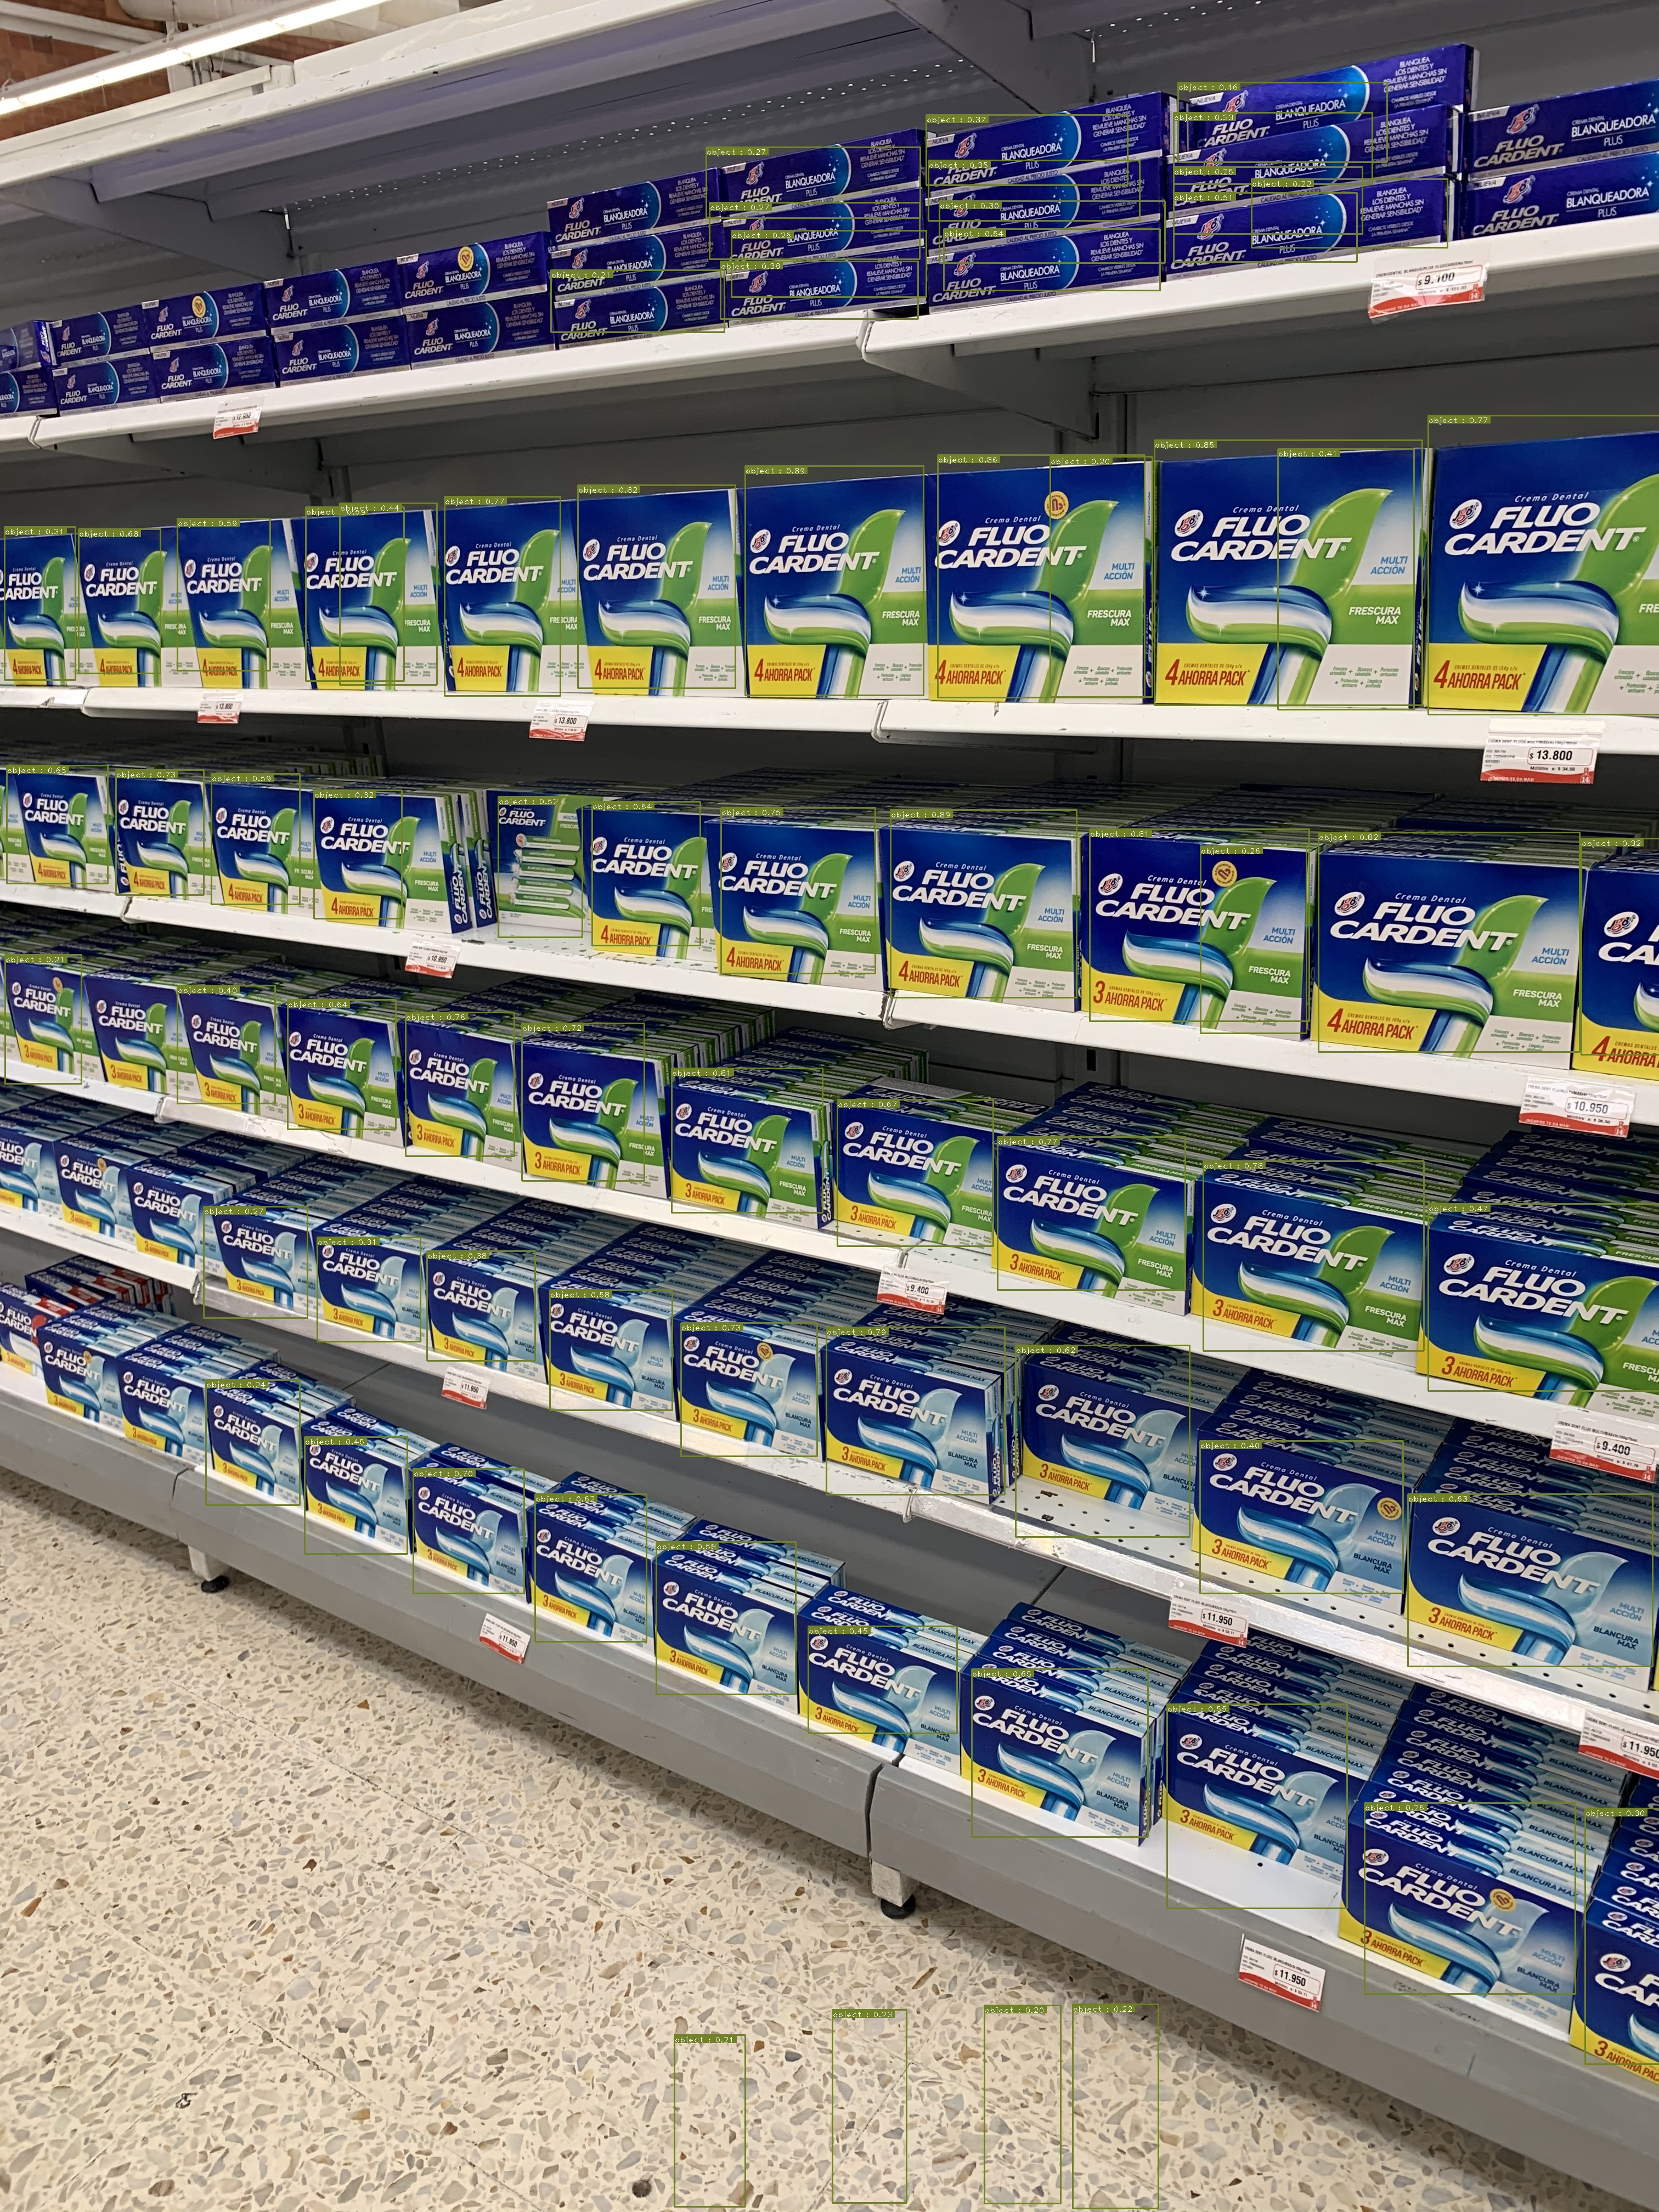

In [ ]:
from IPython.display import Image
Image(filename='output.jpg') 

# Test

In [ ]:
import os
import sys
sys.path.append("Monk_Object_Detection/4_efficientdet/lib/");

In [ ]:
from infer_detector import Infer

In [ ]:
gtf = Infer();

In [ ]:
!mkdir trained


In [ ]:
%cp /content/drive/MyDrive/Tesis/objectDetectionWeights/Efficientdet/signatrix_efficientdet_coco.onnx  /content/trained/signatrix_efficientdet_coco.onnx
%cp /content/drive/MyDrive/Tesis/objectDetectionWeights/Efficientdet/signatrix_efficientdet_coco.pth /content/trained/signatrix_efficientdet_coco.pth

In [ ]:
gtf.Model(model_dir="trained/")

In [ ]:
test_images = [f for f in os.listdir('/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/test/images') if f.endswith('.jpg')]

for img in test_images:
  img_path = "/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/test/images/" + img;
  duration, scores, labels, boxes = gtf.Predict(img_path, class_list, vis_threshold=0.2);
  print(boxes.cpu().numpy())
  break

Done. (0.231s)
[[ 19.613232 153.76309   57.155964 214.4187  ]
 [ 71.44311  227.0951   103.18177  288.63104 ]
 [ 94.34549   39.020325 167.03653  118.57709 ]
 ...
 [127.14842  410.893    151.04332  446.43347 ]
 [ 82.666336 421.52356  119.042725 477.71948 ]
 [ 25.483654 456.95358   60.877224 478.65103 ]]


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
def read_images_IQA(filename):
  f,ans = open(filename,"r"),list()
  for line in f:
    ans.append(line.strip().split()[1])
  f.close()
  return ans

In [ ]:

import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from itertools import product
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


#https://towardsdatascience.com/evaluating-performance-of-an-object-detection-model-137a349c517b
INF = float('inf')
test_images_names = [f for f in os.listdir('/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/test/images') if f.endswith('.jpg')]

test_images_names.sort()


def get_images_and_boxes(filename):
    ans = {}
    f = open(filename,"r")
    for line in f:
        line = line.strip().split(",")
        if(ans.get(line[0]) == None):
            ans[line[0]] = [[int(line[i]) for i in range(1,5)]]
        else:
            ans[line[0]].append([int(line[i]) for i in range(1,5)])
    f.close()
    return ans


def drawBox(boxes, image):
    for i in range (0, len(boxes)):
        cv2.rectangle(image,(boxes[i][0],boxes[i][1]),(boxes[i][2],boxes[i][3]),(255, 0, 0),1)
    b,g,r = cv2.split(image)           # get b, g, r
    image = cv2.merge([r,g,b])     # switch it to r, g, b
        
    #cv2.namedWindow('final', cv2.WINDOW_NORMAL)
    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def get_model_scores(pred_boxes):
    """Creates a dictionary of from model_scores to image ids.
    Args:
        pred_boxes (dict): dict of dicts of 'boxes' and 'scores'
    Returns:
        dict: keys are model_scores and values are image ids (usually filenames)
    """
    model_score={}
    for img_id, val in pred_boxes.items():
        for score in val['scores']:
            if score not in model_score.keys():
                model_score[score]=[img_id]
            else:
                model_score[score].append(img_id)
    return model_score

def calc_iou( gt_bbox, pred_bbox):
    '''
    This function takes the predicted bounding box and ground truth bounding box and 
    return the IoU ratio
    '''
    x_topleft_gt, y_topleft_gt, x_bottomright_gt, y_bottomright_gt= gt_bbox
    x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p= pred_bbox
    
    if (x_topleft_gt > x_bottomright_gt) or (y_topleft_gt> y_bottomright_gt):
        return 0
        #raise AssertionError("Ground Truth Bounding Box is not correct")
    if (x_topleft_p > x_bottomright_p) or (y_topleft_p> y_bottomright_p):
        #print("Predicted Bounding Box is not correct",x_topleft_p, x_bottomright_p,y_topleft_p,y_bottomright_gt)
        return 0
        #raise AssertionError("Predicted Bounding Box is not correct",x_topleft_p, x_bottomright_p,y_topleft_p,y_bottomright_gt)
        
         
    #if the GT bbox and predcited BBox do not overlap then iou=0
    if(x_bottomright_gt< x_topleft_p):
        # If bottom right of x-coordinate  GT  bbox is less than or above the top left of x coordinate of  the predicted BBox
        
        return 0.0
    if(y_bottomright_gt< y_topleft_p):  # If bottom right of y-coordinate  GT  bbox is less than or above the top left of y coordinate of  the predicted BBox
        
        return 0.0
    if(x_topleft_gt> x_bottomright_p): # If bottom right of x-coordinate  GT  bbox is greater than or below the bottom right  of x coordinate of  the predcited BBox
        
        return 0.0
    if(y_topleft_gt> y_bottomright_p): # If bottom right of y-coordinate  GT  bbox is greater than or below the bottom right  of y coordinate of  the predcited BBox
        
        return 0.0
    
    
    GT_bbox_area = (x_bottomright_gt -  x_topleft_gt + 1) * (  y_bottomright_gt -y_topleft_gt + 1)
    Pred_bbox_area =(x_bottomright_p - x_topleft_p + 1 ) * ( y_bottomright_p -y_topleft_p + 1)
    
    x_top_left =np.max([x_topleft_gt, x_topleft_p])
    y_top_left = np.max([y_topleft_gt, y_topleft_p])
    x_bottom_right = np.min([x_bottomright_gt, x_bottomright_p])
    y_bottom_right = np.min([y_bottomright_gt, y_bottomright_p])
    
    intersection_area = (x_bottom_right- x_top_left + 1) * (y_bottom_right-y_top_left  + 1)
    
    union_area = (GT_bbox_area + Pred_bbox_area - intersection_area)
   
    return intersection_area/union_area

def calc_precision_recall(image_results):
    """Calculates precision and recall from the set of images
    Args:
        img_results (dict): dictionary formatted like:
            {
                'img_id1': {'true_pos': int, 'false_pos': int, 'false_neg': int},
                'img_id2': ...
                ...
            }
    Returns:
        tuple: of floats of (precision, recall)
    """
    true_positive=0
    false_positive=0
    false_negative=0
    for img_id, res in image_results.items():
        true_positive +=res['true_positive']
        false_positive += res['false_positive']
        false_negative += res['false_negative']
        try:
            precision = true_positive/(true_positive+ false_positive)
        except ZeroDivisionError:
            precision=0.0
        try:
            recall = true_positive/(true_positive + false_negative)
        except ZeroDivisionError:
            recall=0.0
    return (precision, recall)


def get_single_image_results(gt_boxes, pred_boxes, iou_thr):
    """Calculates number of true_pos, false_pos, false_neg from single batch of boxes.
    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (dict): dict of dicts of 'boxes' (formatted like `gt_boxes`)
            and 'scores'
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.
    Returns:
        dict: true positives (int), false positives (int), false negatives (int)
    """
    all_pred_indices= range(len(pred_boxes))
    all_gt_indices=range(len(gt_boxes))
    if len(all_pred_indices)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    if len(all_gt_indices)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    
    gt_idx_thr=[]
    pred_idx_thr=[]
    ious=[]
    for ipb, pred_box in enumerate(pred_boxes):
        for igb, gt_box in enumerate(gt_boxes):
            iou= calc_iou(gt_box, pred_box)
            
            if iou >iou_thr:
                gt_idx_thr.append(igb)
                pred_idx_thr.append(ipb)
                ious.append(iou)
    iou_sort = np.argsort(ious)[::1]
    if len(iou_sort)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    else:
        gt_match_idx=[]
        pred_match_idx=[]
        for idx in iou_sort:
            gt_idx=gt_idx_thr[idx]
            pr_idx= pred_idx_thr[idx]
            # If the boxes are unmatched, add them to matches
            if(gt_idx not in gt_match_idx) and (pr_idx not in pred_match_idx):
                gt_match_idx.append(gt_idx)
                pred_match_idx.append(pr_idx)
        tp= len(gt_match_idx)
        fp= len(pred_boxes) - len(pred_match_idx)
        fn = len(gt_boxes) - len(gt_match_idx)
    return {'true_positive': tp, 'false_positive': fp, 'false_negative': fn}

def  get_avg_precision_at_iou(gt_boxes, pred_bb, iou_thr=0.5):
    
    model_scores = get_model_scores(pred_bb)
    sorted_model_scores= sorted(model_scores.keys())# Sort the predicted boxes in descending order (lowest scoring boxes first):
    for img_id in pred_bb.keys():
        
        arg_sort = np.argsort(pred_bb[img_id]['scores'])
        pred_bb[img_id]['scores'] = np.array(pred_bb[img_id]['scores'])[arg_sort].tolist()
        pred_bb[img_id]['boxes'] = np.array(pred_bb[img_id]['boxes'])[arg_sort].tolist()
    pred_boxes_pruned = deepcopy(pred_bb)
        
    
    precisions = []
    recalls = []
    model_thrs = []
    img_results = {}# Loop over model score thresholds and calculate precision, recall
    for ithr, model_score_thr in enumerate(sorted_model_scores[:-1]):
            # On first iteration, define img_results for the first time:
        #print("Model score : ", model_score_thr)
        img_ids = gt_boxes.keys() if ithr == 0 else model_scores[model_score_thr]
        for img_id in img_ids:
            #print("Image {0} processed".format(img_id))
            gt_boxes_img = gt_boxes[img_id]
            box_scores = pred_boxes_pruned[img_id]['scores']
            start_idx = 0
            for score in box_scores:
                if score <= model_score_thr:
                    pred_boxes_pruned[img_id]
                    start_idx += 1
                else:
                    break 
            # Remove boxes, scores of lower than threshold scores:
            pred_boxes_pruned[img_id]['scores']= pred_boxes_pruned[img_id]['scores'][start_idx:]
            pred_boxes_pruned[img_id]['boxes']= pred_boxes_pruned[img_id]['boxes'][start_idx:]# Recalculate image results for this image
            #print(img_id)
            img_results[img_id] = get_single_image_results(gt_boxes_img, pred_boxes_pruned[img_id]['boxes'], iou_thr)# calculate precision and recall
        prec, rec = calc_precision_recall(img_results)
        precisions.append(prec)
        recalls.append(rec)
        model_thrs.append(model_score_thr)
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    prec_at_rec = []
    print("Processing recall...")
    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            args= np.argwhere(recalls>recall_level).flatten()
            prec= max(precisions[args])
            #print(recalls,"Recall")
            #print(      recall_level,"Recall Level")
            #print(       args, "Args")
            #print(       prec, "precision")
        except ValueError:
            prec=0.0
        prec_at_rec.append(prec)
    avg_prec = np.mean(prec_at_rec) 
    return {
        'avg_prec': avg_prec,
        'precisions': precisions,
        'recalls': recalls,
        'model_thrs': model_thrs}


def compare(path_images,filename,selected_images = None):
    global test_images_names
    i = 0
    gt_boxes = {}
    pred_boxes = {}
    if(selected_images != None):
      test_images_names = [f for f in test_images_names if f in selected_images]
      print(test_images_names)
    images_and_boxes = get_images_and_boxes(filename)
    while i < len(test_images_names):
      
        img_path = path_images+'/'+test_images_names[i]
        duration, scores, labels, boxes = gtf.Predict(img_path, class_list, vis_threshold=0.);

        real_boxes = images_and_boxes[test_images_names[i]]
        
       
        gt_boxes[test_images_names[i]] = [list(bbox) for bbox in real_boxes]

        # image = cv2.imread(path_images+"/"+test_images_names[i],3)#,cv2.COLOR_BGR2RGB)
        
        # b,g,r = cv2.split(image)           # get b, g, r
        # image = cv2.merge([r,g,b])     # switch it to r, g, b
        # #drawBox(real_boxes,image)
        
        
        
        pred_boxes[test_images_names[i]] = {"boxes":[list(bbox) for bbox in boxes.cpu().numpy()],"scores":list(scores.cpu().numpy())}
        
        
        # drawBox(pred_boxes[test_images_names[i]]['boxes'],image)

        # image = cv2.imread(path_images+"/"+test_images_names[i],3)#,cv2.COLOR_BGR2RGB)
        # b,g,r = cv2.split(image)           # get b, g, r
        # image = cv2.merge([r,g,b])     # switch it to r, g, b

        # drawBox(gt_boxes[test_images_names[i]],image)
        # #if(i == 0):break
        i += 1
    print("Begining...")
    res = get_avg_precision_at_iou(gt_boxes,pred_boxes,0.6)
    print("\nP: {}".format(np.mean(res['precisions'])))
    print("R: {}".format(np.mean(res['recalls'])))
    print("Ap: {}".format(res['avg_prec']))












In [ ]:

path_images = '/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/test/images'

filename = '/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/annotations/annotations_test.csv'

compare(path_images,filename)

In [ ]:


test_images_names = [f for f in os.listdir('/content/drive/MyDrive/Tesis/testImages/Images') if f.endswith('.jpg')]


path_images = '/content/drive/MyDrive/Tesis/testImages/Images'

filename = '/content/drive/MyDrive/Tesis/testImages/anns_test.csv'


compare(path_images,filename)

Done. (0.049s)
Done. (0.046s)
Done. (0.046s)
Done. (0.047s)
Done. (0.046s)
Done. (0.046s)
Done. (0.047s)
Done. (0.046s)
Done. (0.046s)
Done. (0.046s)
Done. (0.048s)
Done. (0.046s)
Done. (0.046s)
Done. (0.046s)
Done. (0.047s)
Done. (0.045s)
Done. (0.046s)
Done. (0.046s)
Done. (0.046s)
Done. (0.047s)
Done. (0.046s)
Done. (0.046s)
Done. (0.047s)
Done. (0.046s)
Done. (0.047s)
Done. (0.048s)
Done. (0.047s)
Done. (0.046s)
Done. (0.047s)
Done. (0.046s)
Begining...
Processing recall...

P: 0.16865069055463497
R: 0.5171233102895383
Ap: 0.3608458465948079


In [ ]:
test_images_names = [f for f in os.listdir('/content/drive/MyDrive/Tesis/Datasets/Holoselecta/images') if f.endswith('.jpg')]


path_images = '/content/drive/MyDrive/Tesis/Datasets/Holoselecta/images'

filename = '/content/drive/MyDrive/Tesis/Datasets/Holoselecta/annotations/annotations.csv'

compare(path_images,filename)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Done. (0.219s)
Done. (0.046s)
Done. (0.048s)
Done. (0.046s)
Done. (0.050s)
Done. (0.046s)
Done. (0.046s)
Done. (0.047s)
Done. (0.047s)
Done. (0.046s)
Done. (0.047s)
Done. (0.048s)
Done. (0.046s)
Done. (0.048s)
Done. (0.047s)
Done. (0.047s)
Done. (0.049s)
Done. (0.048s)
Done. (0.048s)
Done. (0.046s)
Done. (0.050s)
Done. (0.050s)
Done. (0.047s)
Done. (0.047s)
Done. (0.048s)
Done. (0.050s)
Done. (0.050s)
Done. (0.049s)
Done. (0.048s)
Done. (0.050s)
Done. (0.049s)
Done. (0.047s)
Done. (0.050s)
Done. (0.050s)
Done. (0.050s)
Done. (0.047s)
Done. (0.049s)
Done. (0.048s)
Done. (0.049s)
Done. (0.048s)
Done. (0.049s)
Done. (0.049s)
Done. (0.049s)
Done. (0.048s)
Done. (0.049s)
Done. (0.048s)
Done. (0.049s)
Done. (0.049s)
Done. (0.048s)
Done. (0.050s)
Done. (0.050s)
Done. (0.048s)
Done. (0.050s)
Done. (0.048s)
Done. (0.049s)
Done. (0.046s)
Done. (0.046s)
Done. (0.047s)
Done. (0.049s)
Done. (0.048s)
Done. (0.048s)
Done. (0.049s)
Done. (0.046s)
Done. (0.046s)
Done. (0.046s)
Done. (0.048s)
Done. (0.0

In [ ]:
#best images sku110k
selected_images = read_images_IQA("/content/drive/MyDrive/Tesis/resultsIQA/SKU110k_best_images.txt")

test_images_names = [f for f in os.listdir('/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/test/images') if f.endswith('.jpg')]

path_images = '/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/test/images'

filename = '/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/annotations/annotations_test.csv'

compare(path_images,filename,selected_images)

['test_142.jpg', 'test_1425.jpg', 'test_1426.jpg', 'test_1424.jpg', 'test_1423.jpg', 'test_1429.jpg', 'test_1434.jpg', 'test_1432.jpg', 'test_1439.jpg', 'test_1443.jpg', 'test_1445.jpg', 'test_1452.jpg', 'test_1454.jpg', 'test_1453.jpg', 'test_1462.jpg', 'test_147.jpg', 'test_1465.jpg', 'test_15.jpg', 'test_152.jpg', 'test_157.jpg', 'test_159.jpg', 'test_166.jpg', 'test_168.jpg', 'test_169.jpg', 'test_177.jpg', 'test_18.jpg', 'test_181.jpg', 'test_192.jpg', 'test_193.jpg', 'test_194.jpg', 'test_201.jpg', 'test_202.jpg', 'test_205.jpg', 'test_206.jpg', 'test_208.jpg', 'test_211.jpg', 'test_214.jpg', 'test_217.jpg', 'test_219.jpg', 'test_220.jpg', 'test_222.jpg', 'test_223.jpg', 'test_224.jpg', 'test_226.jpg', 'test_227.jpg', 'test_230.jpg', 'test_231.jpg', 'test_10.jpg', 'test_1001.jpg', 'test_1003.jpg', 'test_1009.jpg', 'test_1016.jpg', 'test_1018.jpg', 'test_1020.jpg', 'test_1028.jpg', 'test_1027.jpg', 'test_1029.jpg', 'test_1031.jpg', 'test_1043.jpg', 'test_1045.jpg', 'test_1047.jpg'

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Done. (0.233s)
Done. (0.051s)
Done. (0.050s)
Done. (0.051s)
Done. (0.050s)
Done. (0.050s)
Done. (0.045s)
Done. (0.051s)
Done. (0.051s)
Done. (0.051s)
Done. (0.052s)
Done. (0.050s)
Done. (0.050s)
Done. (0.049s)
Done. (0.051s)
Done. (0.052s)
Done. (0.050s)
Done. (0.050s)
Done. (0.049s)
Done. (0.051s)
Done. (0.051s)
Done. (0.052s)
Done. (0.049s)
Done. (0.052s)
Done. (0.050s)
Done. (0.050s)
Done. (0.052s)
Done. (0.050s)
Done. (0.050s)
Done. (0.050s)
Done. (0.051s)
Done. (0.051s)
Done. (0.051s)
Done. (0.051s)
Done. (0.051s)
Done. (0.051s)
Done. (0.050s)
Done. (0.052s)
Done. (0.052s)
Done. (0.051s)
Done. (0.051s)
Done. (0.052s)
Done. (0.051s)
Done. (0.051s)
Done. (0.051s)
Done. (0.050s)
Done. (0.049s)
Done. (0.049s)
Done. (0.050s)
Done. (0.052s)
Done. (0.051s)
Done. (0.051s)
Done. (0.049s)
Done. (0.052s)
Done. (0.051s)
Done. (0.049s)
Done. (0.050s)
Done. (0.051s)
Done. (0.050s)
Done. (0.051s)
Done. (0.051s)
Done. (0.051s)
Done. (0.050s)
Done. (0.051s)
Done. (0.045s)
Done. (0.051s)
Done. (0.0

In [ ]:
#worst images sku110k
selected_images = read_images_IQA("/content/drive/MyDrive/Tesis/resultsIQA/SKU110k_worst_images.txt")

test_images_names = [f for f in os.listdir('/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/test/images') if f.endswith('.jpg')]

path_images = '/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/test/images'

filename = '/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/annotations/annotations_test.csv'

compare(path_images,filename,selected_images)

['test_1428.jpg', 'test_1433.jpg', 'test_1438.jpg', 'test_1436.jpg', 'test_1442.jpg', 'test_1444.jpg', 'test_1446.jpg', 'test_1449.jpg', 'test_1458.jpg', 'test_148.jpg', 'test_158.jpg', 'test_160.jpg', 'test_161.jpg', 'test_165.jpg', 'test_170.jpg', 'test_175.jpg', 'test_176.jpg', 'test_180.jpg', 'test_182.jpg', 'test_184.jpg', 'test_187.jpg', 'test_190.jpg', 'test_196.jpg', 'test_199.jpg', 'test_2.jpg', 'test_204.jpg', 'test_207.jpg', 'test_209.jpg', 'test_215.jpg', 'test_22.jpg', 'test_221.jpg', 'test_229.jpg', 'test_0.jpg', 'test_1004.jpg', 'test_1006.jpg', 'test_1011.jpg', 'test_1014.jpg', 'test_1015.jpg', 'test_1021.jpg', 'test_1025.jpg', 'test_1026.jpg', 'test_1032.jpg', 'test_1036.jpg', 'test_1034.jpg', 'test_1038.jpg', 'test_105.jpg', 'test_1056.jpg', 'test_1054.jpg', 'test_1059.jpg', 'test_1061.jpg', 'test_106.jpg', 'test_1066.jpg', 'test_1070.jpg', 'test_1074.jpg', 'test_108.jpg', 'test_1079.jpg', 'test_1080.jpg', 'test_1081.jpg', 'test_1082.jpg', 'test_1087.jpg', 'test_1101.

In [ ]:
#best images productos
selected_images = read_images_IQA("/content/drive/MyDrive/Tesis/resultsIQA/productos_best_images.txt")
test_images_names = [f for f in os.listdir('/content/drive/MyDrive/Tesis/testImages/images') if f.endswith('.jpg')]


path_images = '/content/drive/MyDrive/Tesis/testImages/images'

filename = '/content/drive/MyDrive/Tesis/testImages/anns_test.csv'


compare(path_images,filename,selected_images)

['IMG_1260.jpg', 'IMG_1262.jpg', 'IMG_1263.jpg', 'IMG_1264.jpg', 'IMG_1268.jpg', 'IMG_1276.jpg', 'IMG_1278.jpg', 'IMG_1279.jpg']


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Done. (0.215s)
Done. (0.095s)
Done. (0.094s)
Done. (0.093s)
Done. (0.093s)
Done. (0.092s)
Done. (0.093s)
Done. (0.092s)
Begining...
Processing recall...

P: 0.14121036950475796
R: 0.45304885233322995
Ap: 0.3188186136545249


In [ ]:
#worst images productos
selected_images = read_images_IQA("/content/drive/MyDrive/Tesis/resultsIQA/productos_worst_images.txt")

test_images_names = [f for f in os.listdir('/content/drive/MyDrive/Tesis/testImages/images') if f.endswith('.jpg')]


path_images = '/content/drive/MyDrive/Tesis/testImages/images'

filename = '/content/drive/MyDrive/Tesis/testImages/anns_test.csv'


compare(path_images,filename,selected_images)

['IMG_1266.jpg', 'IMG_1270.jpg', 'IMG_1272.jpg', 'IMG_1274.jpg', 'IMG_1283.jpg', 'IMG_1284.jpg', 'IMG_1286.jpg', 'IMG_1287.jpg']
Done. (0.092s)
Done. (0.092s)
Done. (0.093s)
Done. (0.091s)
Done. (0.123s)
Done. (0.096s)
Done. (0.093s)
Done. (0.093s)
Begining...
Processing recall...

P: 0.16036183349315752
R: 0.4743426379550912
Ap: 0.3345904956177778


In [ ]:
#best images holoselecta

selected_images = read_images_IQA("/content/drive/MyDrive/Tesis/resultsIQA/holoselecta_best_images.txt")

test_images_names = [f for f in os.listdir('/content/drive/MyDrive/Tesis/Datasets/Holoselecta/images') if f.endswith('.jpg')]


path_images = '/content/drive/MyDrive/Tesis/Datasets/Holoselecta/images'

filename = '/content/drive/MyDrive/Tesis/Datasets/Holoselecta/annotations/annotations.csv'

compare(path_images,filename,selected_images)


['IMG_20190206_170714.jpg', 'IMG_20190206_170716.jpg', 'IMG_20181218_164606.jpg', 'IMG_20190430_111942.jpg', 'IMG_20190502_093929.jpg', 'IMG_20181218_165501.jpg', 'IMG_20181218_125954.jpg', 'IMG_20181218_165504.jpg', 'IMG_20181218_165508.jpg', 'IMG_20181218_165652.jpg', 'IMG_20181218_165648.jpg', 'IMG_20181218_165657.jpg', 'IMG_20181218_165931.jpg', 'IMG_20181218_165800.jpg', 'IMG_20181218_165804.jpg', 'IMG_20181218_170046.jpg', 'IMG_20181218_171604.jpg', 'IMG_20181218_171740.jpg', 'IMG_20181218_171800.jpg', 'IMG_20181218_172844.jpg', 'IMG_20181218_173652.jpg', 'IMG_20181218_173035.jpg', 'IMG_20181218_173039.jpg', 'IMG_20181218_173700.jpg', 'IMG_20181218_174501.jpg', 'IMG_20181218_174507.jpg', 'IMG_20181218_174559.jpg', 'IMG_20181218_174605.jpg', 'IMG_20181218_175420.jpg', 'IMG_20190125_113835.jpg', 'IMG_20190125_113830.jpg', 'IMG_20190206_170138.jpg', 'IMG_20190206_170436.jpg', 'IMG_20190206_170142.jpg', 'IMG_20190206_120945.jpg', 'IMG_20190206_170434.jpg', 'IMG_20190206_170619.jpg', 

In [ ]:
#worst images holoselecta

selected_images = read_images_IQA("/content/drive/MyDrive/Tesis/resultsIQA/holoselecta_worst_images.txt")

test_images_names = [f for f in os.listdir('/content/drive/MyDrive/Tesis/Datasets/Holoselecta/images') if f.endswith('.jpg')]


path_images = '/content/drive/MyDrive/Tesis/Datasets/Holoselecta/images'

filename = '/content/drive/MyDrive/Tesis/Datasets/Holoselecta/annotations/annotations.csv'

compare(path_images,filename,selected_images)

['IMG_20190502_094330.jpg', '20190111_111631_HoloLens.jpg', '20190111_111623_HoloLens.jpg', '20190111_111616_HoloLens.jpg', '20190111_111611_HoloLens.jpg', '20190111_111703_HoloLens.jpg', '20190111_111656_HoloLens.jpg', '20190111_111600_HoloLens.jpg', '20190111_115003_HoloLens.jpg', '20190111_111641_HoloLens.jpg', '20190111_111715_HoloLens.jpg', '20190111_111648_HoloLens.jpg', '20190111_111725_HoloLens.jpg', '20190111_115010_HoloLens.jpg', '20190111_115017_HoloLens.jpg', '20190111_115042_HoloLens.jpg', '20190111_111731_HoloLens.jpg', '20190111_115129_HoloLens.jpg', '20190111_115050_HoloLens.jpg', '20190111_115028_HoloLens.jpg', '20190111_115122_HoloLens.jpg', '20190111_115136_HoloLens.jpg', '20190111_115057_HoloLens.jpg', '20190111_115106_HoloLens.jpg', '20190111_115116_HoloLens.jpg', '20190111_115150_HoloLens.jpg', '20190111_115143_HoloLens.jpg', '20190111_115203_HoloLens.jpg', '20190111_115234_HoloLens.jpg', '20190111_115157_HoloLens.jpg', '20190111_115218_HoloLens.jpg', 'IMG_2018121

In [ ]:
import time

test_images = [f for f in os.listdir('/content/drive/MyDrive/Tesis/testImages/images') if f.endswith('.jpg')]
#import random
#img_path = "/content/drive/MyDrive/Tesis/testImages/" + test_images;
for img in test_images:
  img_path = "/content/drive/MyDrive/Tesis/testImages/images/" + img;
  start_time = time.time()
  duration, scores, labels, boxes = gtf.Predict(img_path, class_list, vis_threshold=0.2);
  print("--- %s seconds ---" % (time.time() - start_time))
  break



Done. (0.050s)
--- 1.517056941986084 seconds ---
